# Probe log files

#### Importing packges 

In [1]:
import pathlib
from glob import glob
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")
from polyphys.manage import organizer
from polyphys.probe import prober
from polyphys.manage.parser import SumRuleCyl, TransFociCyl

### Project-specific configuration

In [2]:
# loading databases:
database = '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/'

project_name = 'SumRuleCyl'
hierarchy = '/N*'
thermo_style = 'one'
#project_name = 'TransFoci'
#hierarchy = '/eps*'
#thermo_style = 'multi'

parser_func = {
    "SumRuleCyl": SumRuleCyl,
    "TransFociCyl": TransFociCyl,
}

phase = "logs"
geometry = "biaxial"
group = "bug"
lineage = "whole"
species = "Mon"
thermo_func = {
    "one": prober.thermo_one,
    "multi": prober.thermo_multi
}

save_to = "./"

In [3]:
group = 'bug'
phase= "logs"
space_dbs = glob(database + "N*-logs")
space_dbs = [space.split('/')[-1] for space in space_dbs]
space_dbs.sort()
space_dbs

['N1000D15.0ac1.0-logs',
 'N1000D15.0ac2.0-logs',
 'N2000D20.0ac1.0-logs',
 'N2000D20.0ac2.0-logs',
 'N2000D25.0ac1.0-logs',
 'N2000D25.0ac2.0-logs',
 'N2000D25.0ac4.0-logs',
 'N500D10.0ac0.6-logs',
 'N500D10.0ac0.8-logs',
 'N500D10.0ac1.0-logs']

### Parsing the log files per **project**

In [4]:
thermos = []
run_stats = []
wall_time_stats = []

space_with_segment_lineage = [
    'N500D10.0ac0.6-logs',
    'N500D10.0ac0.8-logs',
    'N500D10.0ac1.0-logs'
]
for space in space_dbs:
    if space in space_with_segment_lineage:
        lineage = 'segment'
    else:
        lineage = 'whole'
    path = pathlib.Path(database +  space)
    path = path.resolve() # convert relative path to absolute one
    input_database = str(path)
    if not pathlib.Path(input_database).exists():
        raise OSError(f"'{input_database}'"
                        "path does not exist.")
    observations = glob(input_database + hierarchy)
    if observations == []:
        raise OSError(
            "File not found in "
            f"'{input_database + hierarchy}'"
            )
    logs = organizer.sort_filenames(observations, fmts=['.log'])
    print(space)
    for log in logs:
        try:
            thermo = thermo_func[thermo_style](
                log[0],
                parser_func[project_name],
                geometry,
                group,
                lineage
            )
            thermos.append(thermo)
        except IndexError:
            print("broken log: ", log)
        log_stat = prober.log_stat(
            log[0],
            parser_func[project_name],
            geometry,
            group,
            lineage
        )
        run_stats.append(log_stat[0])
        wall_time_stats.append(log_stat[1])
output = "-".join([project_name, "allInOne", "thermo"])
thermos = pd.concat(thermos)
thermos.reset_index(inplace=True, drop=True)
thermos.to_parquet(save_to + output + ".parquet.brotli", index=False, compression='brotli')
output = "-".join([project_name, "allInOne", "runStat"])
run_stats = pd.concat(run_stats)
run_stats.reset_index(inplace=True, drop=True)
run_stats.to_csv(save_to + output + ".csv")
output = "-".join([project_name, "allInOne", "wallTimeStat"])
wall_time_stats = pd.concat(wall_time_stats)
wall_time_stats.reset_index(inplace=True, drop=True)
wall_time_stats.to_csv(save_to + output + ".csv")

N1000D15.0ac1.0-logs
broken log:  ('/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/N1000D15.0ac1.0-logs/N1000epsilon5.0r8.0lz308.5sig1.0nc83295dt0.005bdump1000adump5000ens3.log',)
N1000D15.0ac2.0-logs
N2000D20.0ac1.0-logs
broken log:  ('/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/N2000D20.0ac1.0-logs/N2000epsilon5.0r10.5lz336sig1.0nc90720dt0.005bdump1000adump5000ens4.log',)
broken log:  ('/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/N2000D20.0ac1.0-logs/N2000epsilon5.0r10.5lz336sig1.0nc90720dt0.005bdump1000adump5000ens5.log',)
broken log:  ('/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/N2000D20.0ac1.0-logs/N2000epsilon5.0r10.5lz336sig1.0nc90720dt0.005bdump1000adump5000ens6.log',)
broken log:  ('/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/N2000D20.0ac1.0-logs/N2000epsilo

In [6]:
wall_time_stats.columns

Index(['log_name', 'n_cores', 'n_atoms', 'wall_time', 'lineage_name', 'whole',
       'ensemble_long', 'ensemble', 'space', 'filename', 'segment'],
      dtype='object')

# Visualizing the log data:

#### Importing packages

In [7]:
from glob import glob
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from polyphys.visualize import tuner
from polyphys.visualize import plotter
from polyphys.manage.parser import SumRuleCyl, TransFociCyl

### Project-specific configuration

In [ ]:
# loading databases:
project_name = 'SumRuleCyl'
#spaces_to_read = ["N2000D30.0ac4.0","N2000D30.0ac6.0"]
hierarchy = '/N*'

#project_name = 'TransFoci'
#spaces_to_read = ["ns400nl5al5D20ac1"]
#hierarchy = '/eps*'

parser_func = {
    "SumRuleCyl": SumRuleCyl,
    "TransFociCyl": TransFociCyl,
}

phase = "logs"
group = "bug"
species = "Mon"

In [ ]:
group = 'bug'
phase= "logs"
database = '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/'
space_dbs = glob(database + "N*-logs")
space_dbs = [space.split('/')[-1] for space in space_dbs]
space_dbs

### Importing datasets

In [ ]:
thermos = []
run_stats = []
wall_time_stats = []
database = '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/'
project_database = database + "/".join([project_name, phase])
for space in space_dbs:
    df_path = project_name + "-allInOne-"
    df_path = project_database + "/" + df_path
    thermo = pd.read_parquet(df_path + "thermo.parquet.brotli")
    thermos.append(thermo)
    run_stat = pd.read_csv(df_path + "runStat.csv")
    run_stats.append(run_stat)
    wall_time_stat = pd.read_csv(df_path + "wallTimeStat.csv")
    wall_time_stats.append(wall_time_stat)
thermos = pd.concat(thermos, axis=0, ignore_index=True)
thermos.reset_index(inplace=True, drop=True)
run_stats = pd.concat(run_stats, axis=0, ignore_index=True)
run_stats.reset_index(inplace=True, drop=True)
wall_time_stats = pd.concat(wall_time_stats, axis=0, ignore_index=True)
wall_time_stats.reset_index(inplace=True, drop=True)

In [ ]:
#thermos = []
#run_stats = []
#wall_time_stats = []
database = '/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/'
project_database = database + "/".join([project_name, phase])
df_path = project_name + "-allInOne-"
df_path = project_database + "/" + df_path
thermo = pd.read_parquet(df_path + "thermo.parquet.brotli")
thermos.append(thermo)
run_stat = pd.read_csv(df_path + "runStat.csv")
run_stats.append(run_stat)
wall_time_stat = pd.read_csv(df_path + "wallTimeStat.csv")
wall_time_stats.append(wall_time_stat)
thermos = pd.concat(thermos, axis=0, ignore_index=True)
thermos.reset_index(inplace=True, drop=True)
run_stats = pd.concat(run_stats, axis=0, ignore_index=True)
run_stats.reset_index(inplace=True, drop=True)
wall_time_stats = pd.concat(wall_time_stats, axis=0, ignore_index=True)
wall_time_stats.reset_index(inplace=True, drop=True)

In [ ]:
wall_time_stats

## Visualizing the run stats: 

In [ ]:
sel_cols = ['pair_avg_s', 'pair_pct', 'bond_avg_s', 'bond_pct', 'neigh_avg_s',
       'neigh_pct', 'comm_avg_s', 'comm_pct', 'output_avg_s', 'output_pct',
       'modify_avg_s', 'modify_pct', 'other_avg_s', 'other_pct',
       'dangerous_builds']

In [ ]:
agg_funcs = {}
for col in ['pair_avg_s', 'pair_pct', 'bond_avg_s', 'bond_pct', 'neigh_avg_s',
       'neigh_pct', 'comm_avg_s', 'comm_pct', 'output_avg_s', 'output_pct',
       'modify_avg_s', 'modify_pct', 'other_avg_s', 'other_pct']:
    agg_funcs[col] = np.mean
agg_funcs['dangerous_builds'] = np.sum

In [ ]:
run_stats_per_cor_per_atoms = run_stats.groupby(['n_cores','n_atoms'])[sel_cols].agg(agg_funcs)
run_stats_per_cor_per_atoms.reset_index(inplace=True)

In [ ]:
run_stats_per_cor_per_atoms_per_cat = pd.melt(run_stats_per_cor_per_atoms, id_vars=['n_cores','n_atoms'], value_vars= ['pair_pct', 'bond_pct', 'neigh_pct', 'comm_pct',  'output_pct','modify_pct', 'other_pct'], var_name='category',value_name='pct_of_total_time')

In [ ]:
fontsize = 14
save_to = "./"
ext = 'pdf'
new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
sns.set_context(
    font_scale=3,
    rc={
        'font.family': "Times New Roman",
        'mathtext.default': 'regular',
        "text.usetex": True,
        "font.size": fontsize
    }
)
ax_sns = sns.lineplot(
    x='n_atoms',
    y='pct_of_total_time',
    hue='category',
    style='n_cores',
    marker='s',
    data=run_stats_per_cor_per_atoms_per_cat,
    ax=ax
)
ax_sns.set_xlabel(r"# of particles $")
ax_sns.set_ylabel(r"% of the total time")
handles, labels = ax_sns.get_legend_handles_labels()
ax_sns.legend(handles = handles, labels=new_labels, frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
output = "-".join(["runStat", project_name]) + "." + ext
fig.savefig(save_to + output, bbox_inches='tight')

In [10]:
sel_cols = [ 'n_cores', 'n_atoms','step_per_second','dangerous_builds']
agg_funcs = {}
agg_funcs['step_per_second'] = np.mean
agg_funcs['dangerous_builds'] = np.sum

In [11]:
step_per_sec_stats = run_stats.groupby(['n_cores','n_atoms'])[sel_cols].agg(agg_funcs)
step_per_sec_stats.reset_index(inplace=True)

In [12]:
step_per_sec_stats['step_per_second_per_core'] = step_per_sec_stats['step_per_second'] / step_per_sec_stats['n_cores']

In [23]:
step_per_sec_stats[step_per_sec_stats['n_cores']==4].sort_values(by='n_atoms')

,n_cores,n_atoms,step_per_second,dangerous_builds,step_per_second_per_core
10,4,5157,2089.239317,0,522.309829
11,4,5473,1979.787950,0,494.946988
12,4,5789,1876.593808,0,469.148452
13,4,6104,1757.659575,0,439.414894
14,4,6206,2630.595142,0,657.648785
15,4,6420,1676.489667,0,419.122417
16,4,6650,2982.186855,8,745.546714
17,4,6736,1570.961533,0,392.740383
18,4,6857,2552.698150,0,638.174537
19,4,7051,1517.530283,0,379.382571


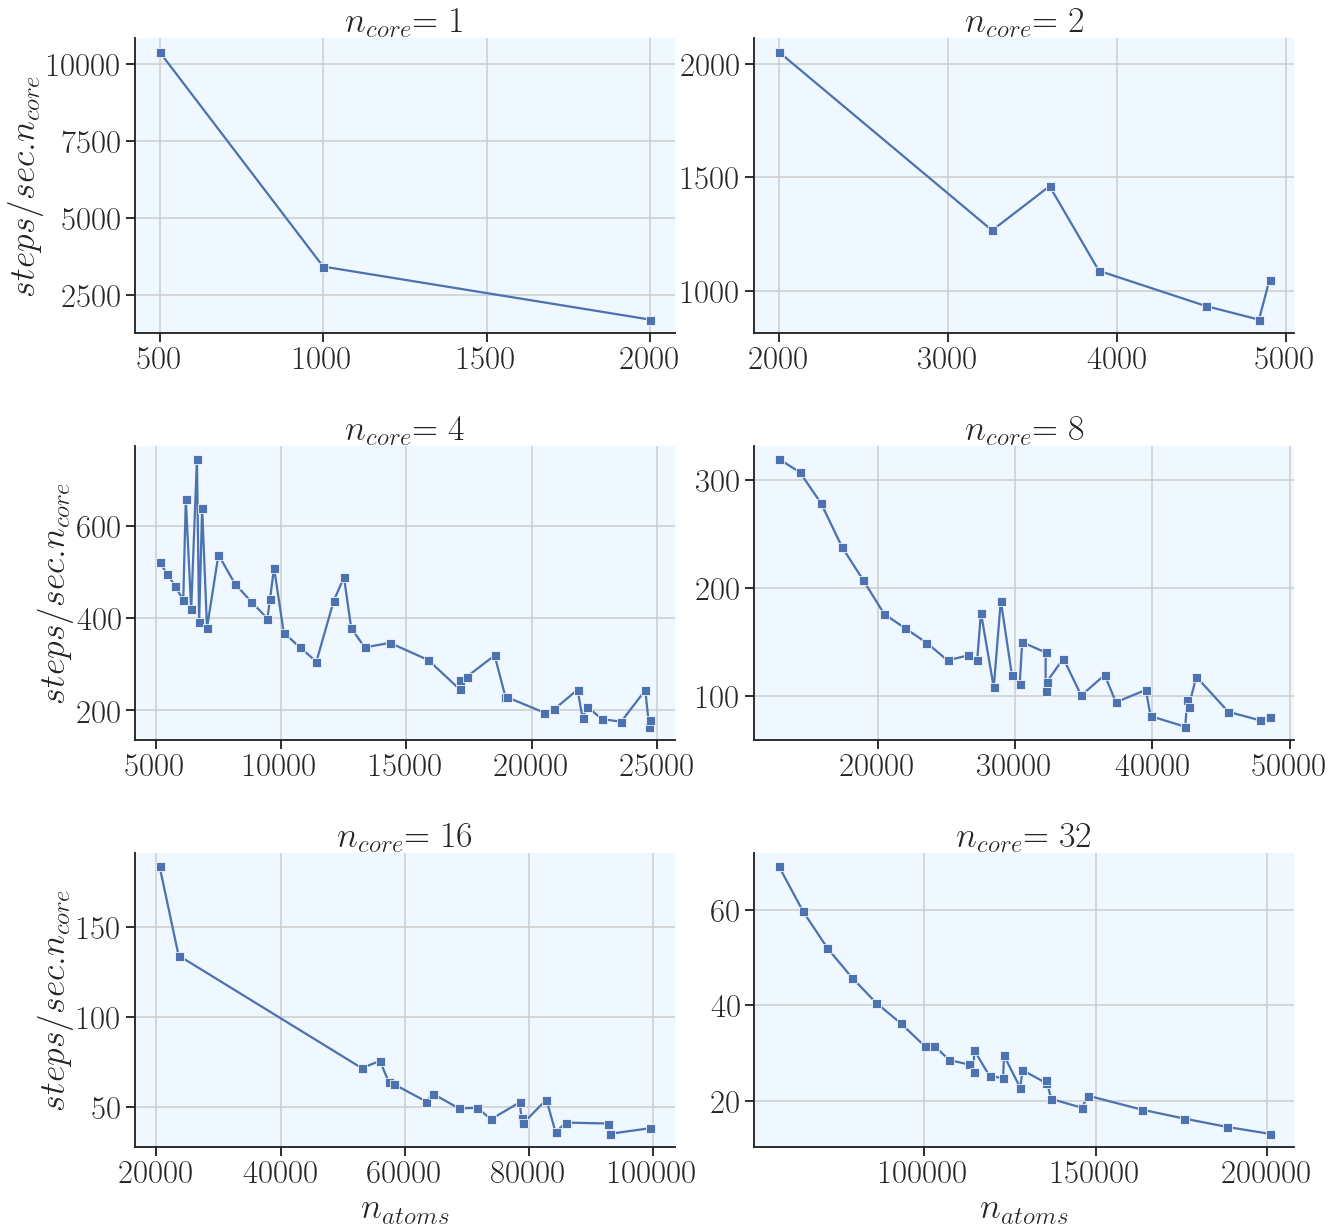

In [14]:
fontsize = 14
save_to = "./"
ext = 'pdf'
new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 6
aspect = 1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True,        
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}

sns.set_theme(
    context=plot_context,
    style='ticks',
  #  palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
stat_grid = sns.relplot(
    x='n_atoms',
    y='step_per_second_per_core',
    col='n_cores',
    col_wrap=2,
    marker='s',
    data=step_per_sec_stats,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    facet_kws=facet_kws,
)
col_attr = 'n_cores'
attr_labels = {
    'n_cores': r"$n_{{core}}$"
}
stat_grid.set_xlabels(r"$n_{atoms}$")
stat_grid.set_ylabels(r"${steps}/{sec.n_{core}}$")
stat_grid.set_titles(attr_labels[col_attr] + r"$={col_name}$")
stat_grid.tight_layout(w_pad=0)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#output = "-".join(["runStat", project_name]) + "." + ext
#fig.savefig(save_to + output, bbox_inches='tight')

### Visualizing wall-time stats

In [15]:
wall_time_stats.columns

Index(['log_name', 'n_cores', 'n_atoms', 'wall_time', 'lineage_name', 'whole',
       'ensemble_long', 'ensemble', 'space', 'filename', 'segment'],
      dtype='object')

In [31]:
wall_time_per_whole = wall_time_stats.groupby(['whole'])['ensemble','whole','n_cores', 'n_atoms','wall_time_hr'].agg({'ensemble': 'last','whole':'last','n_cores':'last', 'n_atoms':'last', 'wall_time_hr': np.sum})
wall_time_per_whole.reset_index(inplace=True,drop=True)
wall_time_per_ensemble = wall_time_per_whole.groupby(['ensemble'])['ensemble','n_cores','n_atoms','wall_time_hr'].agg({'ensemble': 'last','n_cores':'last', 'n_atoms':'last', 'wall_time_hr': np.mean})
wall_time_per_ensemble.reset_index(inplace=True,drop=True)
wall_time_per_ensemble

,ensemble,n_cores,n_atoms,wall_time_hr
0,N1000D15.0ac1.0nc0,1.0,1000.0,5.945278
1,N1000D15.0ac1.0nc20824,4.0,21824.0,20.326111
2,N1000D15.0ac1.0nc31236,8.0,32236.0,18.019757
3,N1000D15.0ac1.0nc41648,8.0,42648.0,28.052118
4,N1000D15.0ac1.0nc46854,8.0,47854.0,32.874965
...,...,...,...,...
107,N500D10.0ac1.0nc21525,8.0,22025.0,76.643646
108,N500D10.0ac1.0nc23063,16.0,23563.0,79.264896
109,N500D10.0ac1.0nc24600,8.0,25100.0,33.203299
110,N500D10.0ac1.0nc6150,4.0,6650.0,28.979583


In [33]:
wall_time_per_ensemble_sorted = wall_time_per_ensemble.sort_values(by=['n_cores','n_atoms'])

In [34]:
wall_time_per_ensemble_sorted[wall_time_per_ensemble_sorted.n_cores==2]

,ensemble,n_cores,n_atoms,wall_time_hr
55,N2000D25.0ac2.0nc0,2.0,2000.0,4.866944
67,N2000D25.0ac4.0nc1263,2.0,3263.0,7.879583
13,N1000D15.0ac2.0nc2603,2.0,3603.0,6.819236
68,N2000D25.0ac4.0nc1895,2.0,3895.0,9.187708
69,N2000D25.0ac4.0nc2526,2.0,4526.0,10.716840
70,N2000D25.0ac4.0nc2842,2.0,4842.0,11.455278
14,N1000D15.0ac2.0nc3905,2.0,4905.0,9.498785


In [16]:
wall_time_stats['wall_time_hr'] = pd.to_timedelta(wall_time_stats['wall_time']).apply(lambda x: x.total_seconds()/3600)

In [ ]:
fontsize = 14
save_to = "./"
ext = 'pdf'
#new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
sns.set_context(
    font_scale=3,
    rc={
        'font.family': "Times New Roman",
        'mathtext.default': 'regular',
        "text.usetex": True,
        "font.size": fontsize
    }
)
ax_sns = sns.lineplot(
    x='n_atoms',
    y='wall_time_hr',
    style='n_cores',
    hue='n_cores',
    marker='s',
    data=wall_time_stats,
    ax=ax
)

ax_sns.set_xlabel("# of particles")
ax_sns.set_ylabel("Wall time (hours)")
sns.move_legend(ax_sns, title="# of cores", loc= "upper left", bbox_to_anchor=(1, 1))
output = "-".join(["wallTimeStat", project_name]) + "." + ext
fig.savefig(save_to + output, bbox_inches='tight')
#plt.close()

In [ ]:
fontsize = 14
save_to = "./"
ext = 'pdf'
#new_labels = ['Category', 'Pair', 'Bond', 'Neigh', 'Comm', 'Output', 'Modify', 'Other', '# of cores', '1', '4', '8', '16']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
sns.set_context(
    font_scale=3,
    rc={
        'font.family': "Times New Roman",
        'mathtext.default': 'regular',
        "text.usetex": True,
        "font.size": fontsize
    }
)
ax_sns = sns.lineplot(
    x='n_atoms',
    y='wall_time_hr',
    style='n_cores',
    hue='n_cores',
    marker='s',
    data=wall_time_stats,
    ax=ax
)

ax_sns.set_xlabel("# of particles")
ax_sns.set_ylabel("Wall time (hours)")
sns.move_legend(ax_sns, title="# of cores", loc= "upper left", bbox_to_anchor=(1, 1))
output = "-".join(["wallTimeStat", project_name]) + "." + ext
fig.savefig(save_to + output, bbox_inches='tight')
#plt.close()

### Visualizing thermodynamic data

In [ ]:
thermp_freq = 10000
equilibration_total_steps = 1000000
sampling_first_step = equilibration_total_steps + thermp_freq
thermos_equil = thermos.loc[thermos["Step"]>=sampling_first_step,:]
thermos_equil.reset_index(inplace=True, drop=True)

In [ ]:
thermos_equil.columns

In [ ]:
#sel_cols = ['Step', 'TotEng', 'KinEng', 'Temp', 'PotEng', 'E_bond', 'E_angle',
#       'E_dihed', 'E_impro', 'E_vdwl', 'E_coul', 'E_long', 'Press',
#        'whole', 'ensemble_long', 'ensemble', 'space',
#        'dcyl', 'dmon_large', 'nmon_large',
#        'nmon_small', 'dcrowd', 'dt', 'bdump',
#       'adump', 'ensemble_id',  'phi_c_bulk'] # multi
sel_cols = ['Step', 'Temp', 'E_pair', 'E_mol', 'TotEng', 'Press', 'lineage_name',
       'whole', 'ensemble_long', 'ensemble', 'space', 'nmon', 'epsilon',
       'dcyl', 'lcyl', 'dcrowd', 'ncrowd', 'dt', 'bdump', 'adump',
       'ensemble_id', 'phi_m_bulk', 'rho_m_bulk', 'phi_c_bulk', 'rho_c_bulk'] # one
thermos_equil = thermos_equil.loc[:,sel_cols]

In [ ]:
round_to = 0.025
phi_crds = thermos_equil.loc[:,'phi_c_bulk'].drop_duplicates().sort_values().values
phi_crds = np.round(np.round(phi_crds/round_to) * round_to, 3)
phi_crds = np.unique(phi_crds)
phi_crds.sort()
print(phi_crds)
print("Number of unique phi_c_bulk:", len(phi_crds))
rounding_func = lambda x, round_to: np.round(np.rint((x / round_to)) * round_to, 3)
thermos_equil['phi_c_bulk_round'] = thermos_equil['phi_c_bulk'].apply(
    rounding_func, args=[round_to]
)

In [ ]:
sns.relplot(
    x="Step",
    y="E_bond",
    col='phi_c_bulk_round',
    col_wrap=3,
    hue='ensemble_id',
    ci=None,
    alpha=0.5,
    legend="full",
    kind="line",
    facet_kws={"sharey": False},
    data=thermos_equil
)

In [ ]:
sns.relplot(
    x="Step",
    y="Press",
    col='phi_c_bulk_round',
    col_wrap=3,
    hue='ensemble_id',
    ci=None,
    alpha=0.5,
    legend="full",
    kind="line",
    facet_kws={"sharey": False},
    data=thermos_equil
)

## Not finished: 

In [ ]:
colors = ['royalblue', 'firebrick']
lineage = 'whole'
geometry = 'biaxial'

if len(thermos) % 2 == 0:
    n_cols = len(thermos)//2
else:
    n_cols = len(thermos)//2 + 1
plt.rcParams.update({
    "text.usetex": True, 
})
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['mathtext.default'] = "regular"
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, n_cols, sharex=False, figsize=(9,12))
xdata ='step'
ydata= 'press'
thermp_freq = 10000
equilibration_steps = 1000000
sampling_first_step = equilibration_steps + thermp_freq
sampling_first_row = sampling_first_step // thermp_freq
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    data_info = TransFoci(
            data_path,
            geometry=geometry,
            group='bug',
            lineage=lineage
        )
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True, drop=True)
    #data = data.iloc[sampling_first_row:,:]
    y_mean = data.loc[sampling_first_row:,ydata].mean()
    ax.set_title(fr"$\phi_c^{{bulk}}={np.round(data_info.phi_c_bulk,3)}$")
    ax.axhline(
        y=y_mean, alpha=0.8, ls='--',
        c=color, 
        label=fr"$\bar{{P}}={np.round(y_mean,3)}$"
        )
    ax.plot(
        data.loc[sampling_first_row:,xdata],
        data.loc[sampling_first_row:,ydata], color=color, alpha=0.7,
            label=r"$P(t)$"
    )    
    ax.set_ylabel(r"Pressure, $P(t)$")
    #ax.set_xlabel(r"Time, ${t}/{\Delta t}$")
    ax.set_xlabel(r"Time Step")
    ax.legend()
fname = ydata+"-time-"+data_info.space+"."+'pdf'
fig.tight_layout()
plt.savefig(fname, bbox_inches='tight')
#plt.close()

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 9))
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    #transition_time = 5500
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True)
    #Use of the following options:
    #data = gyr_t[:transition_time] # before transition at t~5500
    data = data['eVdwl'].to_numpy() # after transition at t~5500
    data = data[101:]
    #data = gyr_t # whole date
    result = analyzer.error_calc_block(data, './block_analysis') 
    #ax.plot(result['si'])
    ax.grid(True, which="both")
    ax.errorbar(result['ntransfroms'], result['si'], yerr=result['si_err'], fmt='--o')
    ax.set_xlabel(r"Number of transformation, $n_{block}$")
    ax.set_ylabel(r"Statistical inefficiency, $s(n_{block})$")

In [ ]:
colors = ['royalblue', 'firebrick']
lineage = 'whole'
geometry = 'biaxial'

if len(thermos) % 2 == 0:
    n_cols = len(thermos)//2
else:
    n_cols = len(thermos)//2 + 1
plt.rcParams.update({
    "text.usetex": True, 
})
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['mathtext.default'] = "regular"
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, n_cols, sharex=False, figsize=(9,12))
xdata ='step'
ydata= 'press'
thermp_freq = 10000
equilibration_steps = 1000000
sampling_first_step = equilibration_steps + thermp_freq
sampling_first_row = sampling_first_step // thermp_freq
for idx, (ax, color, (data_path, data_org)) in enumerate(zip(axes.flat, colors, thermos.items())):
    data_info = TransFoci(
            data_path,
            geometry=geometry,
            group='bug',
            lineage=lineage
        )
    data = data_org.copy()
    data.drop_duplicates(inplace=True)
    data.reset_index(inplace=True, drop=True)
    #data = data.iloc[sampling_first_row:,:]
    y_mean = data.loc[sampling_first_row:,ydata].mean()
    ax.set_title(fr"$\phi_c^{{bulk}}={np.round(data_info.phi_c_bulk,3)}$")
    correlations(data.loc[sampling_first_row:,ydata], lags=40)
    ax.set_ylabel(r"Pressure, $P(t)$")
    #ax.set_xlabel(r"Time, ${t}/{\Delta t}$")
    ax.set_xlabel(r"Time Step")
    ax.legend()
fname = ydata+"-time-"+data_info.space+"."+'pdf'
fig.tight_layout()
plt.savefig(fname, bbox_inches='tight')
#plt.close()